In [1]:
import sys
sys.path.append(".venv/lib/python3.11/site-packages")

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
device = torch.device('mps')
model.to("mps")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295296  [   64/60000]
loss: 2.287362  [ 6464/60000]
loss: 2.267199  [12864/60000]
loss: 2.266844  [19264/60000]
loss: 2.246260  [25664/60000]
loss: 2.217001  [32064/60000]
loss: 2.220272  [38464/60000]
loss: 2.183408  [44864/60000]
loss: 2.186144  [51264/60000]
loss: 2.158309  [57664/60000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 2.152969 

Epoch 2
-------------------------------
loss: 2.162719  [   64/60000]
loss: 2.148241  [ 6464/60000]
loss: 2.089993  [12864/60000]
loss: 2.113936  [19264/60000]
loss: 2.047441  [25664/60000]
loss: 1.999355  [32064/60000]
loss: 2.021063  [38464/60000]
loss: 1.939114  [44864/60000]
loss: 1.957119  [51264/60000]
loss: 1.883163  [57664/60000]
Test Error: 
 Accuracy: 57.6%, Avg loss: 1.880772 

Epoch 3
-------------------------------
loss: 1.916588  [   64/60000]
loss: 1.874104  [ 6464/60000]
loss: 1.760077  [12864/60000]
loss: 1.812544  [19264/60000]
loss: 1.685760  [25664/60000]
loss: 1.652367  [32064/600

In [9]:
X, y = next(iter(test_dataloader))

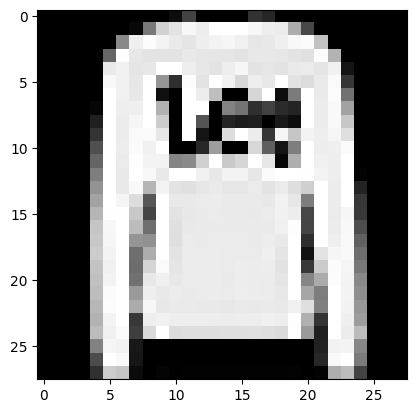

Label: 2


tensor([ 1.6769, -5.1291,  6.6445, -1.3236,  5.2178, -2.6551,  5.1407, -7.6712,
         2.1684, -4.3048], device='mps:0', grad_fn=<SelectBackward0>)

In [11]:
import matplotlib.pyplot as plt
i = 1
img = X[i].squeeze()
label = y[i]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
model(X.to(device))[i]

In [ ]:
torch.save(model, 'model.pth')
model = torch.load('model.pth')